# Create PCoA plots for the metagenomes
- Did sourmash pairwise for 3217 samples (all that we use), and use the jaccard similarities
- Largest influence is space (obviously), then bioproject (obviously)
- Make a PCoA for all samples
- Make individual PCoAs per continent.
- Australia: All in the same bioproject, massive study (2103, 65% of all samples)



In [1]:
# impprts
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.distance import permanova

/var/folders/b5/q0xwwzss4dd82xbt_8lh5qph0000gn/T/ipykernel_17730/1272488753.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# PCoA for all samples together
- All samples, no matter where they came from
- Use custom shapes and color

In [2]:
# open df
df = pd.read_csv("../data/3217_pairwise.csv")

# open all metadata
meta = pd.read_csv("../data/250703_country_loc.csv")  # or sep="\t"


# get sam names
samples = pd.unique(df[['query_name', 'match_name']].values.ravel())

# Pivot to square matrix of Jaccard similarities
pivot_df = df.pivot(index='query_name', columns='match_name', values='jaccard')
pivot_df = pivot_df.reindex(index=samples, columns=samples)

# symetry
sym_df = pivot_df.copy()
sym_df = sym_df.fillna(sym_df.T)

# fill daigonal with 1 1 because similarity between self
np.fill_diagonal(sym_df.values, 1.0)

# and fillna
sym_df = sym_df.fillna(0)

# Convert similarity to dissimilarity matrix
distance_matrix = 1 - sym_df.values

# Convert similarity to dissimilarity
jaccard_distance = 1 - sym_df


# Create a scikit-bio DistanceMatrix object
dm = DistanceMatrix(jaccard_distance.values, ids=sym_df.index)

# Run PCoA
pcoa_results = pcoa(dm)

# to dataframe
pcoa_df = pcoa_results.samples.reset_index().rename(columns={"index": "label"})


pcoa_merged = pd.merge(pcoa_df, meta, on='label')

In [3]:
# set the shapes
custom_shapes = {
    'Australia': 'o',
    'Denmark': 'o',
    'France': 's',
    'Austria': '^',
    'Norway': 'D',
    'Germany': 'p',
    'Spain': 'X',
    'USA': 'o',
    'Canada': 's',
    'China': 'o',
    'South Korea': 's',
    'Thailand': '^',
    'uncalculated': 'o',
}
continent_colors = {
    'Europe': '#ffb703',         # yellow
    'North America': '#219ebc',  # light blue
    'Asia': '#fb8500',           # orange
    'Australia': '#023047',        # dark blue
    'unknown': '#7f7f7f'         # gray
}

# Plot the PCoA 

In [ ]:
# plot cc and cs
plt.figure(figsize=(10,10))
ax = sns.scatterplot(
    data=pcoa_merged,
    x="PC1", y="PC2",
    hue="continent",     # color by continent
    style="country",
    palette=continent_colors,
    markers=custom_shapes,# shape by country
    s=100                # optional: size of points
)
#ax.legend_.remove()
plt.xlabel(f"PCoA1 ({pcoa_results.proportion_explained[0]*100:.1f}% var)")
plt.ylabel(f"PCoA2 ({pcoa_results.proportion_explained[1]*100:.1f}% var)")
plt.grid(True)
plt.tight_layout()
#plt.savefig("../plots/3217_pcoa.legend.pdf")
plt.show()


/var/folders/b5/q0xwwzss4dd82xbt_8lh5qph0000gn/T/ipykernel_23085/2487306785.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PCoA1 ({pcoa_results.proportion_explained[0]*100:.1f}% var)")
/var/folders/b5/q0xwwzss4dd82xbt_8lh5qph0000gn/T/ipykernel_23085/2487306785.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PCoA2 ({pcoa_results.proportion_explained[1]*100:.1f}% var)")


#  plot per continent
- For each contnent create subplot
- Color with country, and bioproject

In [5]:
# functions to subset df on either continent or country
def subset_continent(df, continent):
    samples = meta.loc[meta['continent'] == continent, 'label']
    dm = sym_df.loc[samples, samples]
    dm = DistanceMatrix(1 - dm.values, ids=dm.index)
    pcoa_results = pcoa(dm)
    pcoa_df = pcoa_results.samples.reset_index().rename(columns={'index': 'label'})
    pcoa_merged = pd.merge(pcoa_df, meta, on='label')
    return pcoa_merged, pcoa_results

# country
def subset_country(df, country):
    samples = meta.loc[meta['country'] == country, 'label']
    dm = sym_df.loc[samples, samples]
    dm = DistanceMatrix(1 - dm.values, ids=dm.index)
    pcoa_results = pcoa(dm)
    pcoa_df = pcoa_results.samples.reset_index().rename(columns={'index': 'label'})
    pcoa_merged = pd.merge(pcoa_df, meta, on='label')
    
    return pcoa_merged, pcoa_results

In [6]:
# do for each continent: Example, Europe
pcoa_merged_conti, pcoa_results_conti = subset_continent(df, 'Australia')

In [8]:
pcoa_merged_conti

,label,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC2097,PC2098,PC2099,PC2100,PC2101,PC2102,PC2103,country,continent,bioproject
0,SRR11124652,0.178809,-0.165912,-0.047459,0.015202,-0.047678,0.058372,0.008925,-0.000444,-0.038059,...,0.003572,0.000602,0.000193,0.000738,0.000440,-0.000016,-0.0,Australia,Australia,PRJNA526405
1,SRR11124655,0.207579,-0.122282,-0.038460,0.049256,-0.078149,-0.021201,-0.044529,0.017748,-0.005224,...,-0.000154,0.001040,-0.001092,-0.000034,0.000352,-0.000166,-0.0,Australia,Australia,PRJNA526405
2,SRR11124656,0.161912,-0.127701,-0.076199,0.091822,-0.055693,-0.044375,-0.043525,0.014264,-0.024489,...,0.000404,0.000768,0.000217,-0.000032,0.000256,0.000098,-0.0,Australia,Australia,PRJNA526405
3,SRR11124657,0.123594,-0.035565,-0.072524,0.098643,-0.019168,-0.073527,-0.116690,0.039511,-0.009171,...,0.000029,-0.000264,-0.001049,0.000228,0.000260,0.000250,-0.0,Australia,Australia,PRJNA526405
4,SRR11124660,0.112830,-0.054870,-0.100987,0.081714,-0.048663,-0.076151,-0.047366,0.004329,0.022962,...,0.001576,0.000322,-0.000427,0.000606,-0.000749,0.000533,-0.0,Australia,Australia,PRJNA526405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098,SRR8960982,-0.236935,-0.128631,0.123571,-0.001266,0.024512,-0.014267,-0.033216,0.029281,-0.003953,...,-0.000302,0.000599,0.000524,0.000137,0.000270,-0.000563,-0.0,Australia,Australia,PRJNA526405
2099,SRR8960983,-0.020747,-0.083075,0.160748,0.008488,-0.019409,0.003161,0.005305,0.081695,0.004976,...,0.000781,-0.000287,-0.000276,0.000083,0.000475,-0.000075,-0.0,Australia,Australia,PRJNA526405
2100,SRR8960984,-0.165205,-0.052595,0.113419,-0.018806,-0.027860,0.037825,-0.031663,0.088062,0.002983,...,0.000122,-0.000258,-0.000542,-0.000372,0.000030,-0.000055,-0.0,Australia,Australia,PRJNA526405
2101,SRR8960985,-0.168696,-0.052918,0.126115,-0.008224,-0.049685,0.026384,-0.023666,0.093675,-0.016414,...,-0.000361,0.000436,0.000486,-0.000083,0.000361,-0.000129,-0.0,Australia,Australia,PRJNA526405


/var/folders/b5/q0xwwzss4dd82xbt_8lh5qph0000gn/T/ipykernel_23085/3826469495.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results_conti.proportion_explained[0]*100:.1f}% var)")
/var/folders/b5/q0xwwzss4dd82xbt_8lh5qph0000gn/T/ipykernel_23085/3826469495.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PC2 ({pcoa_results_conti.proportion_explained[1]*100:.1f}% var)")


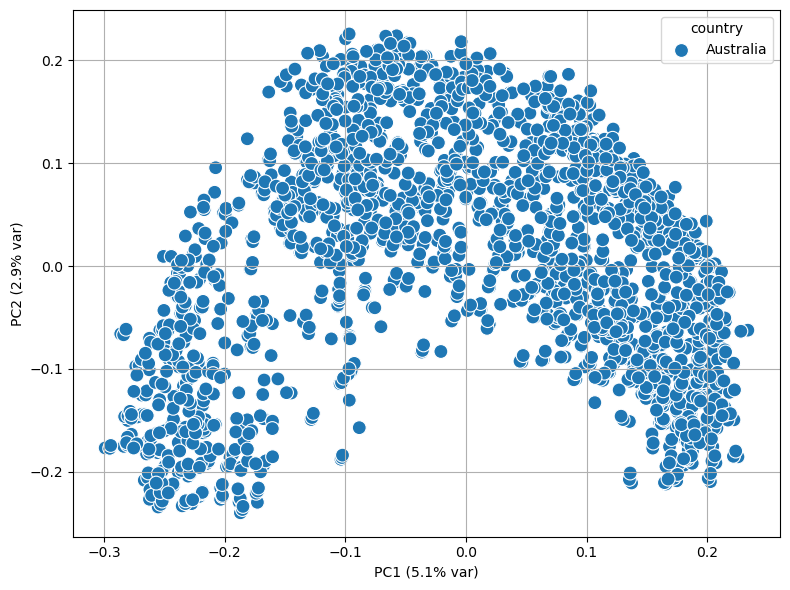

In [9]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(
    data=pcoa_merged_conti,
    x='PC1', y='PC2',
    style='country',
    markers=custom_shapes,
    s=100
)
#ax.legend_.remove()
plt.xlabel(f"PC1 ({pcoa_results_conti.proportion_explained[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pcoa_results_conti.proportion_explained[1]*100:.1f}% var)")
plt.grid(True)
plt.tight_layout()
#plt.savefig("../plots/3217_pcoa.eur.color_country.legend.pdf")
plt.show()


# Plot australia
- For all other continents, there is a clear bioproject and country signal
- The samples from australia all come from the same project, but it's hard to find the signal. 
- paper: https://academic.oup.com/gigascience/article/10/6/giab039/6291567#493864288

There is a time component, then a treatment component, and theres also mothers

In [10]:
# Open the australian metadata
meta_aus =  pd.read_csv("../data/250708_only_aus_used.csv")
# remove the []
meta_aus['date'] = meta_aus['collection_date_sam'].str.strip("[]").str.strip("'").str.strip('"')
meta_aus['host_sex_sam'] = meta_aus['host_sex_sam'].str.strip("[]").str.strip("'").str.strip('"')
meta_aus['cohort_sam'] = meta_aus['cohort_sam'].str.strip("[]").str.strip("'").str.strip('"')
# set index
#meta_aus= meta_aus.set_index('acc')

In [11]:
# dAus subset
pcoa_merged_conti, pcoa_results_conti = subset_continent(df, 'Australia')
# merge with meta
pcoa_merged = pd.merge(pcoa_merged_conti, meta_aus, left_on='label', right_on='acc', how='left')


In [12]:
pcoa_merged['date'] = pd.to_datetime(pcoa_merged['date'])

# Convert to days since the first sample
pcoa_merged['days'] = (pcoa_merged['date'] - pcoa_merged['date'].min()).dt.days

In [13]:
pcoa_merged['days'] = pd.to_numeric(pcoa_merged['days'])
pcoa_merged['timepoint'] = pd.to_numeric(pcoa_merged['timepoint'])

In [32]:
# plt.figure(figsize=(8,6))
# ax = sns.scatterplot(
#     data=pcoa_merged,
#     x='PC1', y='PC2',
#     hue='timepoint',
#     palette='viridis',
#     style='cohort',
#     s=100,
#     alpha=0.9
# )
# #ax.legend_.remove()
# plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}% var)")
# plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}% var)")
# plt.grid(True)
# plt.tight_layout()
# #plt.savefig("../plots/continent_pcoa/aus.timepoint.nolegend.pdf")
# plt.show()

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

norm = mcolors.Normalize(vmin=pcoa_merged['timepoint'].min(), vmax=pcoa_merged['timepoint'].max())
cmap = cm.get_cmap('PiYG')
cohorts = [c for c in pcoa_merged['cohort'].unique() if c != 'mother']
markers = ['o', 's', '^', 'D', 'v', 'P', '*', '8']
marker_map = {cohort: markers[i % len(markers)] for i, cohort in enumerate(cohorts)}

plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current Axes object

for cohort in cohorts:
    subset = pcoa_merged[pcoa_merged['cohort'] == cohort]
    ax.scatter(
        subset['PC1'], subset['PC2'],
        c=subset['days'],
        cmap=cmap,
        norm=norm,
        s=100,
        alpha=0.8,
        edgecolor='k',
        marker=marker_map[cohort],
        label=cohort
    )

# Create ScalarMappable for colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Dummy array for colorbar

# Attach colorbar to the correct axes
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Days since start')

ax.set_xlabel(f"PC3 ({pcoa_results.proportion_explained[0]*100:.1f}% var)")
ax.set_ylabel(f"PC4 ({pcoa_results.proportion_explained[1]*100:.1f}% var)")
ax.legend(title='Cohort')
ax.grid(True)
plt.tight_layout()
plt.tight_layout()
#plt.savefig('../plots/Aus_time_treat.excmother.pdf')
plt.show()


/var/folders/b5/q0xwwzss4dd82xbt_8lh5qph0000gn/T/ipykernel_63028/918845195.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('PiYG')
/var/folders/b5/q0xwwzss4dd82xbt_8lh5qph0000gn/T/ipykernel_63028/918845195.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_xlabel(f"PC3 ({pcoa_results.proportion_explained[0]*100:.1f}% var)")
/var/folders/b5/q0xwwzss4dd82xbt_8lh5qph0000gn/T/ipykernel_63028/918845195.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

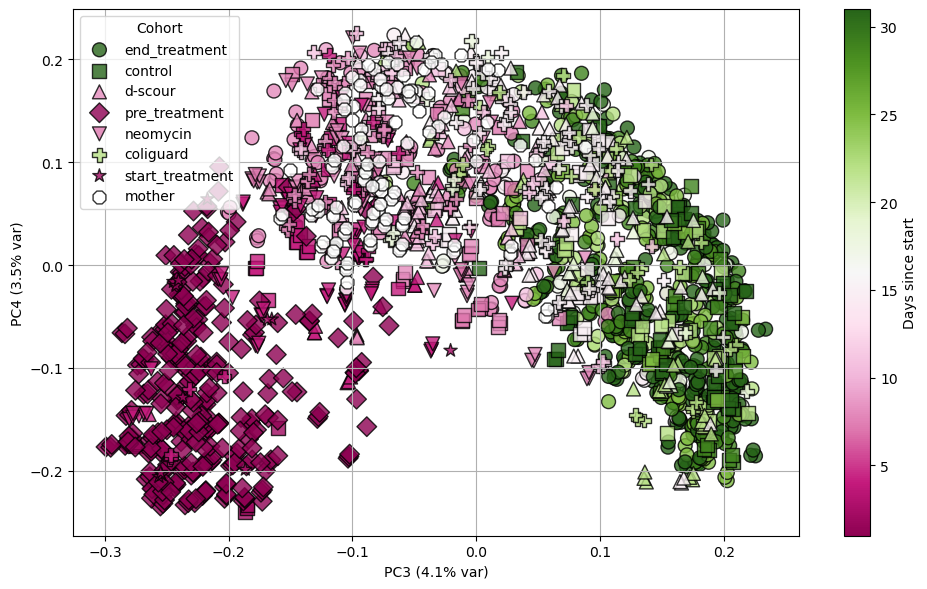

In [33]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

norm = mcolors.Normalize(vmin=pcoa_merged['timepoint'].min(), vmax=pcoa_merged['timepoint'].max())
cmap = cm.get_cmap('PiYG')
cohorts = pcoa_merged['cohort'].unique()
markers = ['o', 's', '^', 'D', 'v', 'P', '*', '8']
marker_map = {cohort: markers[i % len(markers)] for i, cohort in enumerate(cohorts)}

plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current Axes object

for cohort in cohorts:
    subset = pcoa_merged[pcoa_merged['cohort'] == cohort]
    color = 'white' if cohort == 'mother' else subset['days']

    ax.scatter(
        subset['PC1'], subset['PC2'],
        c=color,
        cmap=None if cohort == 'mother' else cmap,
        norm=None if cohort == 'mother' else norm,
        s=100,
        alpha=0.8,
        edgecolor='k',
        marker=marker_map[cohort],
        label=cohort
    )

# Create ScalarMappable for colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Dummy array for colorbar

# Attach colorbar to the correct axes
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Days since start')

ax.set_xlabel(f"PC3 ({pcoa_results.proportion_explained[0]*100:.1f}% var)")
ax.set_ylabel(f"PC4 ({pcoa_results.proportion_explained[1]*100:.1f}% var)")
ax.legend(title='Cohort')
ax.grid(True)
plt.tight_layout()
plt.tight_layout()
#plt.savefig('../plots/Aus_time_treat.inclmother.pdf')
plt.show()
